<h1 style="font-size:50px;">Predicting the closing price stock price using time steps 60</h1>



In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn import metrics

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
AAPL = pd.read_csv("/content/drive/MyDrive/AAPL.csv")
ABB = pd.read_csv("/content/drive/MyDrive/ABB.csv")
ABBV = pd.read_csv("/content/drive/MyDrive/ABBV.csv")
AMGN = pd.read_csv("/content/drive/MyDrive/AMGN.csv")
AEP = pd.read_csv("/content/drive/MyDrive/AEP.csv")


print(AAPL.info())
print(ABB.info())
print(ABBV.info())
print(AMGN.info())
print(AEP.info())

print(AAPL.head())
print(ABB.head())
print(ABBV.head())
print(AMGN.head())
print(AEP.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1258 non-null   object 
 1   Open       1258 non-null   float64
 2   High       1258 non-null   float64
 3   Low        1258 non-null   float64
 4   Close      1258 non-null   float64
 5   Adj Close  1258 non-null   float64
 6   Volume     1258 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 68.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1258 non-null   object 
 1   Open       1258 non-null   float64
 2   High       1258 non-null   float64
 3   Low        1258 non-null   float64
 4   Close      1258 non-null   float64
 5   Adj Close  1258 non-null   float64
 6   Volume     1258 non-null   int64  


In [ ]:
def find_and_replace_null_with_mean(df, name):
    null_rows = df[df.isnull().any(axis=1)]
    if not null_rows.empty:
        print(f"Các dòng chứa giá trị null trong {name}:")
        print(null_rows)


        for column in df.columns:
            if df[column].isnull().any():
                column_mean = df[column].mean()
                df[column].fillna(column_mean, inplace=True)
                print(f"Đã thay thế giá trị null trong cột {column} bằng giá trị mean của cột ({column_mean})")

    else:
        print(f"Không có giá trị null trong {name}.")

    return df

AAPL = find_and_replace_null_with_mean(AAPL, "AAPL")
ABB = find_and_replace_null_with_mean(ABB, "ABB")
ABBV = find_and_replace_null_with_mean(ABBV, "ABBV")
AMGN = find_and_replace_null_with_mean(AMGN, "AMGN")
AEP = find_and_replace_null_with_mean(AEP, "AEP")

Không có giá trị null trong AAPL.
Không có giá trị null trong ABB.
Không có giá trị null trong ABBV.
Không có giá trị null trong AMGN.
Không có giá trị null trong AEP.


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [ ]:
def train_and_evaluate_lstm_model_60(company_data):
    # Create a new dataframe with only the 'Close' column
    data = company_data.filter(['Close'])

    # Convert the dataframe to a numpy array
    dataset = data.values

    # Get the number of rows to train the model on
    training_data_len = int(np.ceil(len(dataset) * 0.95))

    # Scale the data
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(dataset)

    # Create the training data set
    train_data = scaled_data[0:int(training_data_len), :]

    # Split the data into x_train and y_train data sets
    x_train = []
    y_train = []

    for i in range(60, len(train_data)):
        x_train.append(train_data[i-60:i, 0])
        y_train.append(train_data[i, 0])

        if i <= 61:
            print(x_train)
            print(y_train)
            print()

    # Convert the x_train and y_train to numpy arrays
    x_train, y_train = np.array(x_train), np.array(y_train)

    # Reshape the data
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    model.fit(x_train, y_train, batch_size=1, epochs=5)

    # Create the testing data set
    test_data = scaled_data[training_data_len - 60:, :]

    # Create the data sets x_test and y_test
    x_test = []
    y_test = dataset[training_data_len:, :]

    for i in range(60, len(test_data)):
        x_test.append(test_data[i-60:i, 0])

    # Convert the data to a numpy array
    x_test = np.array(x_test)

    # Reshape the data
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    # Get the models predicted price values
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)

    # Get the root mean squared error (RMSE)
    rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))

    return model, scaler, predictions, rmse, data, training_data_len


In [ ]:
def plot_predictions(data, training_data_len, predictions, company_name):
    # Create the training and validation data
    train = data[:training_data_len]
    valid = data[training_data_len:]
    valid['Predictions'] = predictions

    # Visualize the training and validation data along with predictions
    plt.figure(figsize=(16, 6))
    plt.title(f'Model Predictions for {company_name}')
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price USD ($)', fontsize=18)
    plt.plot(train['Close'], label='Train Data')
    plt.plot(valid[['Close', 'Predictions']])
    plt.axvline(x=valid.index[0], color='k', linestyle='--', linewidth=0.5)  # Separate train and valid data
    plt.legend(['Train Data', 'Validation Data', 'Predictions'], loc='lower right')
    plt.show()

    # Plot only validation data and predictions
    plt.figure(figsize=(16, 6))
    plt.title(f'Model Predictions vs Validation Data for {company_name}')
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price USD ($)', fontsize=18)
    plt.plot(valid['Close'], label='Validation Data')
    plt.plot(valid['Predictions'], label='Predictions')
    plt.legend(['Validation Data', 'Predictions'], loc='lower right')
    plt.show()


<h1 style="font-size:20px;">Prediction for AAPL</h1>



In [ ]:
model_AAPL, scaler_AAPL, predictions_AAPL, rmse_AAPL, data_AAPL, training_data_len_AAPL = train_and_evaluate_lstm_model_60(AAPL)

[array([0.37533978, 0.36908503, 0.37705523, 0.38255782, 0.35920134,
       0.35636432, 0.3685044 , 0.38590958, 0.39686206, 0.40807845,
       0.41088912, 0.41113986, 0.40665327, 0.40848748, 0.39621546,
       0.37345279, 0.36242111, 0.38371908, 0.36495475, 0.35478079,
       0.35731437, 0.37069484, 0.36455883, 0.34580769, 0.32677945,
       0.32371803, 0.33039506, 0.31349129, 0.31561584, 0.32227968,
       0.34211287, 0.33527749, 0.31948219, 0.28939591, 0.32131639,
       0.29404078, 0.29861968, 0.28899999, 0.28168956, 0.27023567,
       0.27184555, 0.24579716, 0.25611622, 0.25378053, 0.22098915,
       0.19426773, 0.20655299, 0.20097119, 0.20106357, 0.19311974,
       0.1782613 , 0.18097965, 0.23118947, 0.22482907, 0.22587158,
       0.23880342, 0.26259536, 0.25632736, 0.25389935, 0.26237097])]
[0.2569871188437628]

[array([0.37533978, 0.36908503, 0.37705523, 0.38255782, 0.35920134,
       0.35636432, 0.3685044 , 0.38590958, 0.39686206, 0.40807845,
       0.41088912, 0.41113986, 0.406

<ipython-input-64-fd5faebe6330>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


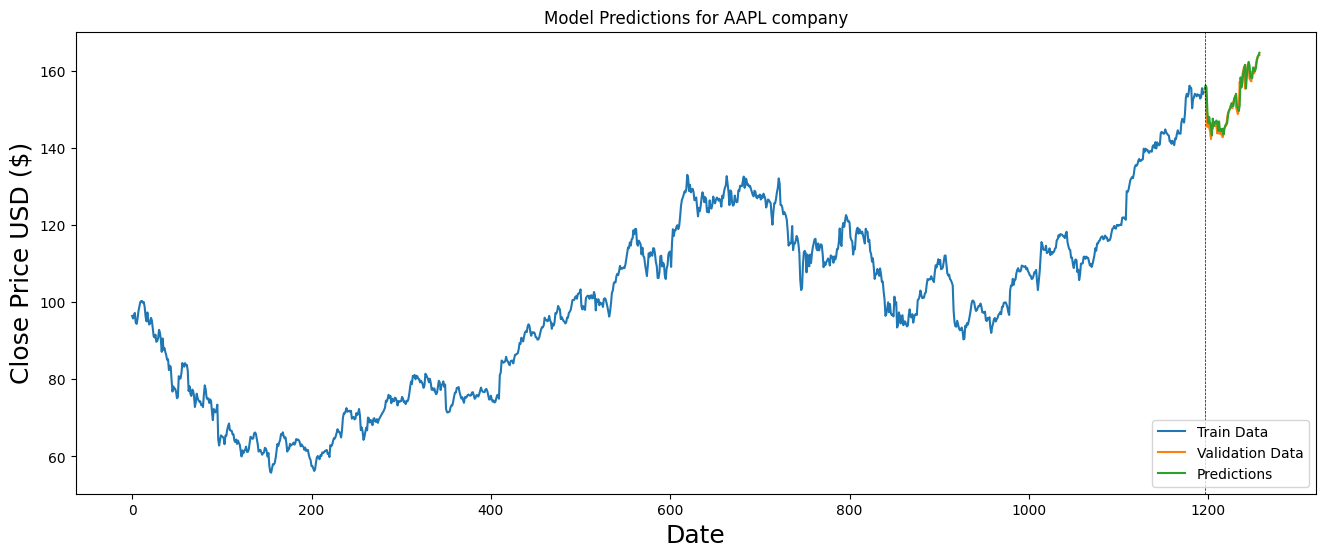

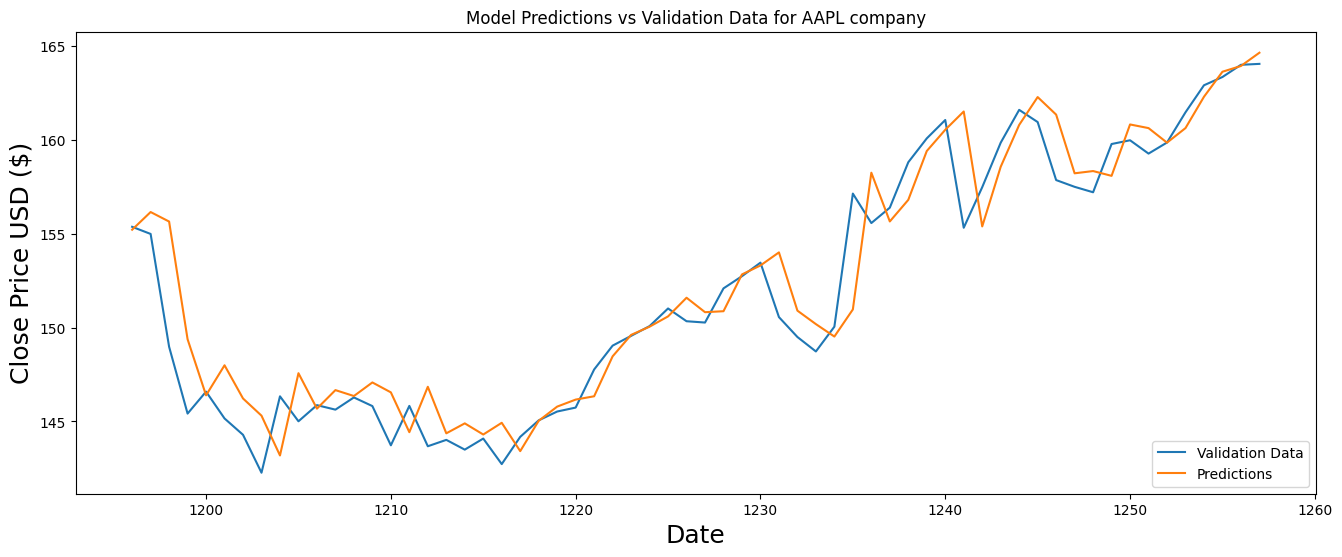

In [ ]:
plot_predictions(data_AAPL, training_data_len_AAPL, predictions_AAPL, "AAPL company")

<h1 style="font-size:20px;">Prediction for ABB</h1>



In [ ]:
model_ABB, scaler_ABB, predictions_ABB, rmse_ABB, data_ABB, training_data_len_ABB = train_and_evaluate_lstm_model_60(ABB)

[array([0.10698104, 0.11423399, 0.16772446, 0.23481421, 0.2248415 ,
       0.25747967, 0.27198547, 0.30915682, 0.35992762, 0.34723478,
       0.32184965, 0.33726216, 0.31006353, 0.31187676, 0.30099725,
       0.2692658 , 0.25566634, 0.28286498, 0.23934739, 0.26110623,
       0.27561203, 0.26745247, 0.2991842 , 0.30281058, 0.28558474,
       0.24750696, 0.22665456, 0.24932001, 0.25657296, 0.2692658 ,
       0.29193125, 0.31731638, 0.33454222, 0.29555763, 0.31822309,
       0.25838629, 0.24569363, 0.22121494, 0.19310986, 0.18132365,
       0.20308248, 0.19220316, 0.19764287, 0.22756127, 0.20761567,
       0.20126943, 0.19310986, 0.19582954, 0.17497741, 0.15775157,
       0.15321857, 0.14777895, 0.18041703, 0.17588403, 0.20126943,
       0.24932001, 0.2547599 , 0.25385329, 0.28286498, 0.30190387])]
[0.304623816443897]

[array([0.10698104, 0.11423399, 0.16772446, 0.23481421, 0.2248415 ,
       0.25747967, 0.27198547, 0.30915682, 0.35992762, 0.34723478,
       0.32184965, 0.33726216, 0.3100

<ipython-input-64-fd5faebe6330>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


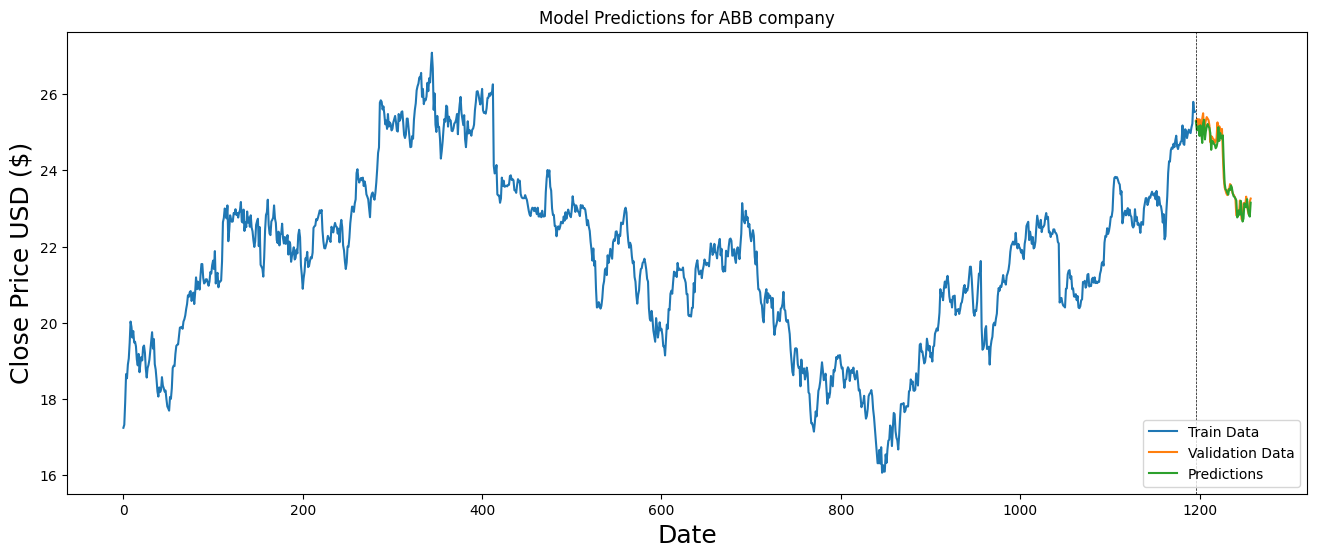

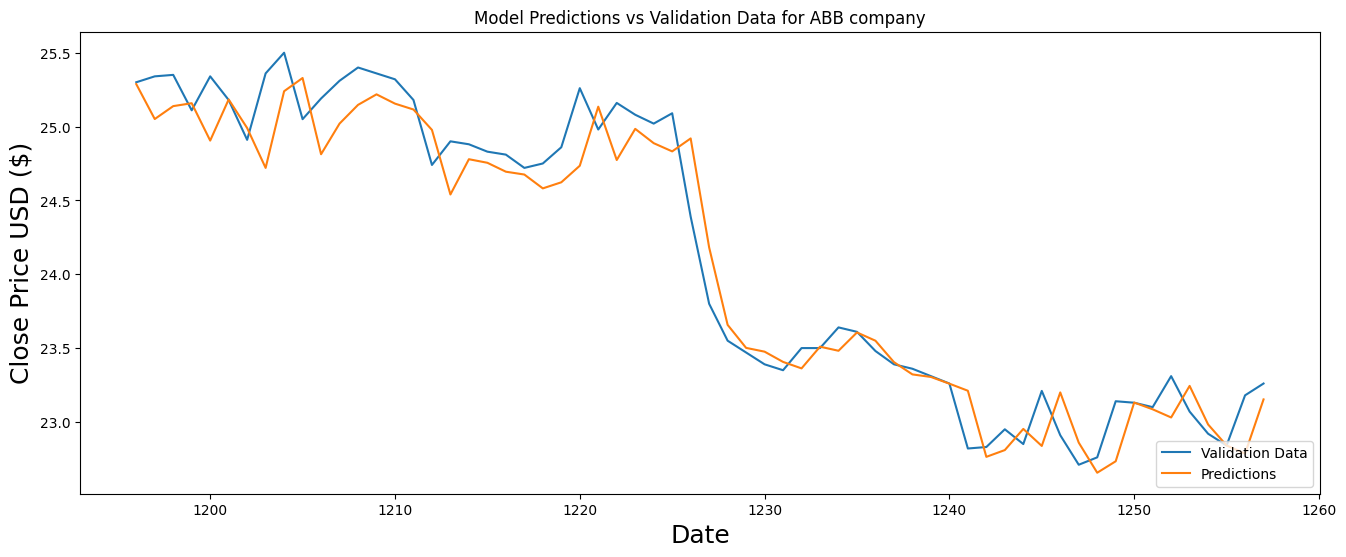

In [ ]:
plot_predictions(data_ABB, training_data_len_ABB, predictions_ABB, "ABB company")

<h1 style="font-size:20px;">Prediction for ABBV</h1>



In [ ]:
model_ABBV, scaler_ABBV, predictions_ABBV, rmse_ABBV, data_ABBV, training_data_len_ABBV = train_and_evaluate_lstm_model_60(ABBV)

[array([0.03380484, 0.02685215, 0.01630305, 0.0179813 , 0.        ,
       0.00455533, 0.00695279, 0.00335649, 0.00911055, 0.02133779,
       0.04387442, 0.06497241, 0.08655001, 0.06497241, 0.09805802,
       0.0899065 , 0.09326298, 0.07624071, 0.08631029, 0.07719974,
       0.0714457 , 0.0831935 , 0.08559099, 0.08367303, 0.08223448,
       0.06497241, 0.06089669, 0.05130662, 0.04099734, 0.03740113,
       0.06856871, 0.09278358, 0.1074083 , 0.11747787, 0.12155359,
       0.11388157, 0.08774874, 0.08103575, 0.07240472, 0.07695994,
       0.09829782, 0.10860712, 0.09110523, 0.09661959, 0.09062582,
       0.08702952, 0.09494124, 0.08295371, 0.08295371, 0.09230405,
       0.11484059, 0.10668907, 0.11148411, 0.12826665, 0.11460089,
       0.1261089 , 0.13450015, 0.15583793, 0.1543995 , 0.16950372])]
[0.17765524281120204]

[array([0.03380484, 0.02685215, 0.01630305, 0.0179813 , 0.        ,
       0.00455533, 0.00695279, 0.00335649, 0.00911055, 0.02133779,
       0.04387442, 0.06497241, 0.08

<ipython-input-64-fd5faebe6330>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


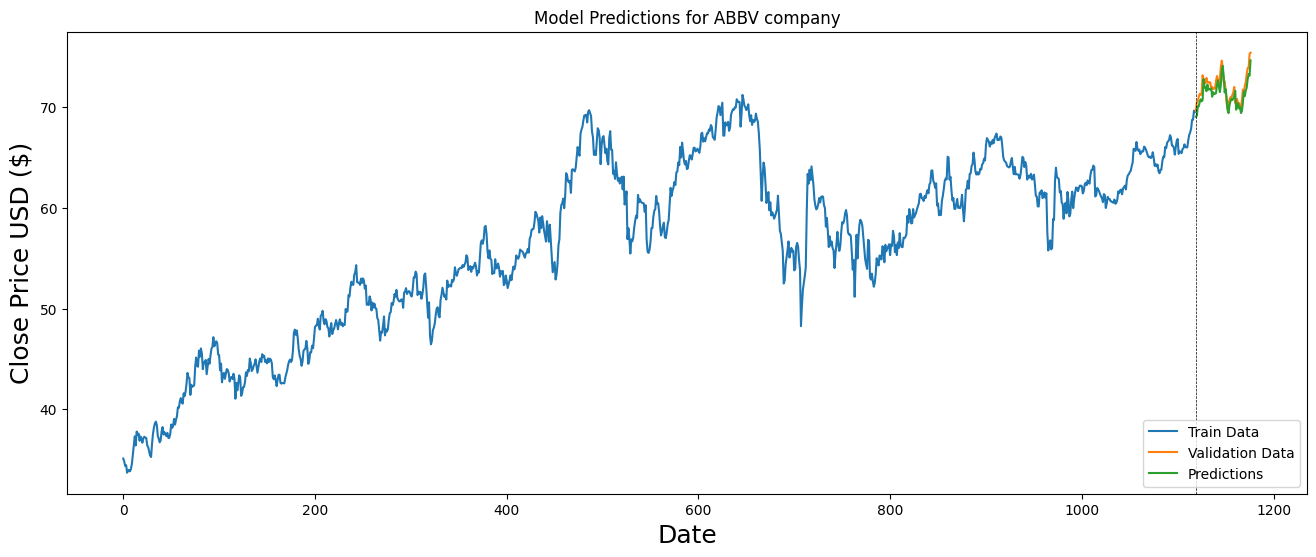

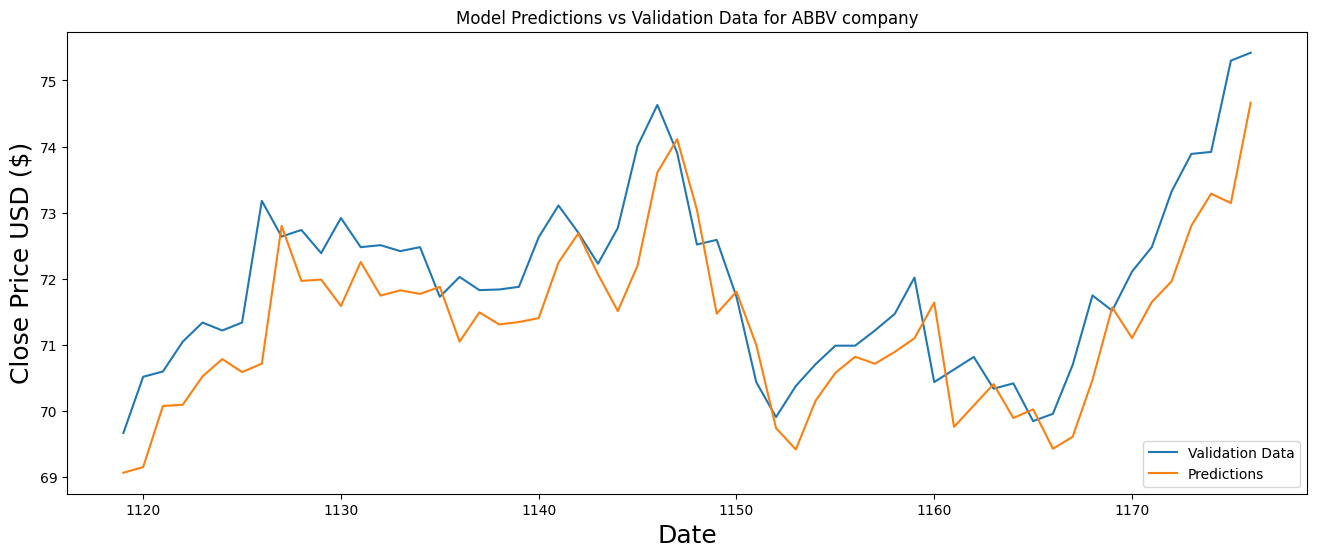

In [ ]:
plot_predictions(data_ABBV, training_data_len_ABBV, predictions_ABBV, "ABBV company")

<h1 style="font-size:20px;">Prediction for AMGN</h1>



In [ ]:
model_AMGN, scaler_AMGN, predictions_AMGN, rmse_AMGN, data_AMGN, training_data_len_AMGN = train_and_evaluate_lstm_model_60(AMGN)

[array([0.02933624, 0.02686686, 0.03407741, 0.02568153, 0.02657054,
       0.02548401, 0.01768077, 0.01935993, 0.        , 0.00721054,
       0.00671671, 0.00345711, 0.00928489, 0.00661792, 0.01531018,
       0.02419989, 0.02074277, 0.02844722, 0.02894113, 0.03674438,
       0.04928879, 0.05373372, 0.0496839 , 0.05511656, 0.04622679,
       0.04020149, 0.03249705, 0.03210193, 0.02607664, 0.04800474,
       0.06598182, 0.0774397 , 0.08326748, 0.05728964, 0.06361124,
       0.05887   , 0.06064795, 0.06608062, 0.061932  , 0.05067164,
       0.05778346, 0.05027653, 0.04928879, 0.05857368, 0.03931247,
       0.03338598, 0.03763332, 0.04109044, 0.04355982, 0.02627416,
       0.02755829, 0.03141051, 0.03990518, 0.05146186, 0.05225208,
       0.06163568, 0.05857368, 0.05551167, 0.0561043 , 0.07161201])]
[0.0734887557542101]

[array([0.02933624, 0.02686686, 0.03407741, 0.02568153, 0.02657054,
       0.02548401, 0.01768077, 0.01935993, 0.        , 0.00721054,
       0.00671671, 0.00345711, 0.009

<ipython-input-64-fd5faebe6330>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


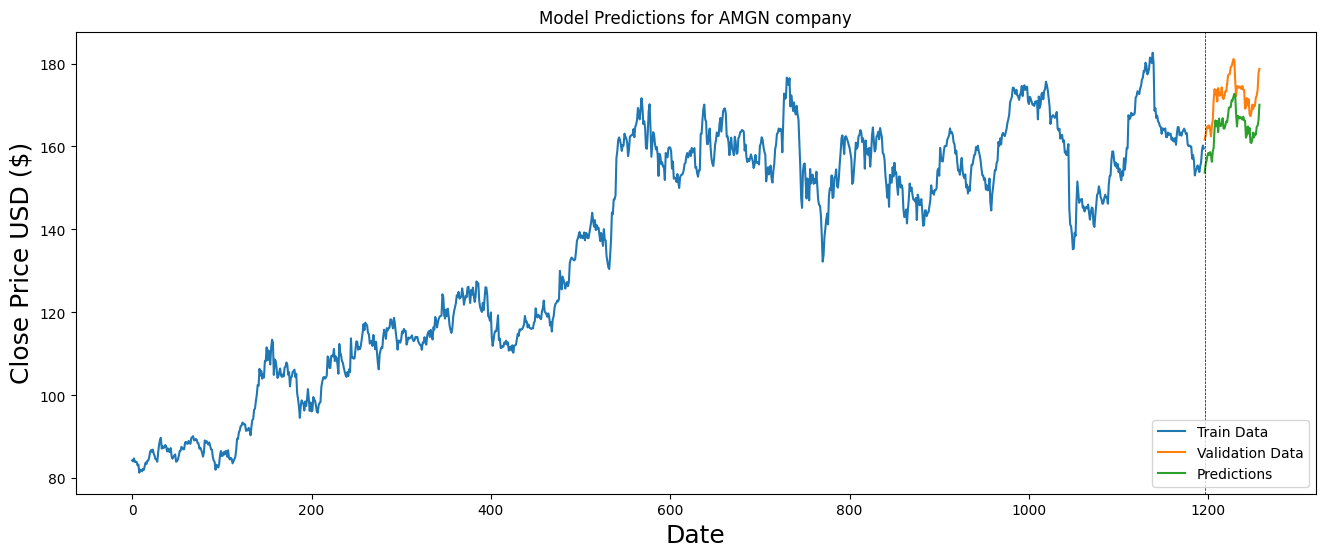

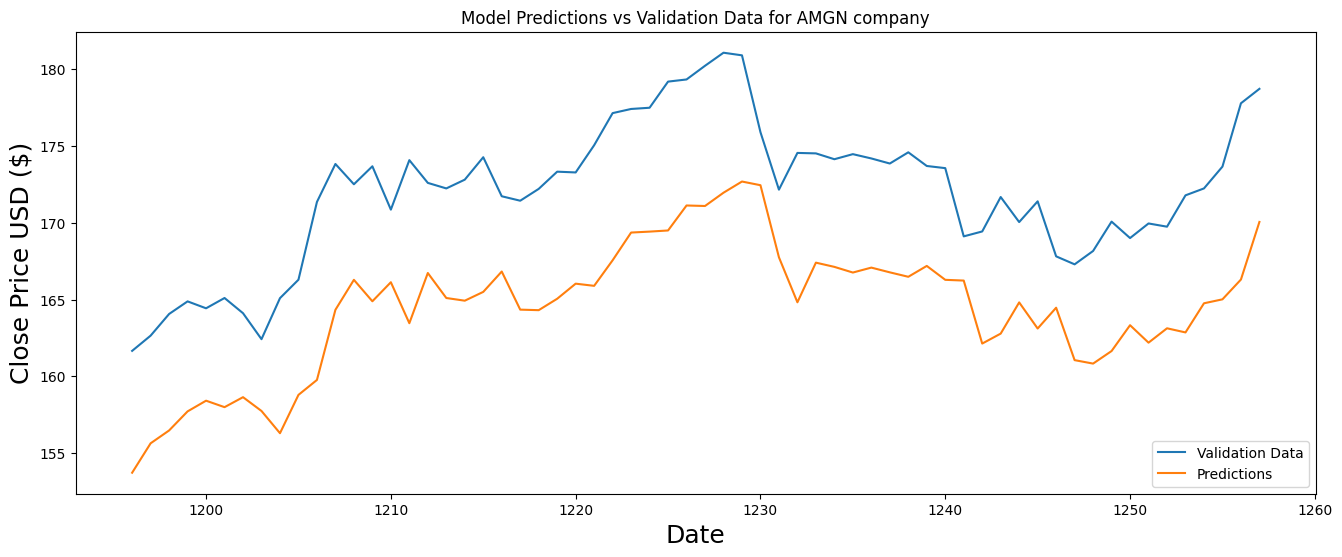

In [ ]:
plot_predictions(data_AMGN, training_data_len_AMGN, predictions_AMGN, "AMGN company")

<h1 style="font-size:20px;">Prediction for AEP</h1>



In [ ]:
model_AEP, scaler_AEP, predictions_AEP, rmse_AEP, data_AEP, training_data_len_AEP = train_and_evaluate_lstm_model_60(AEP)

[array([0.06578153, 0.06004834, 0.07724807, 0.07543754, 0.07332529,
       0.07453232, 0.07664457, 0.09052505, 0.08147257, 0.07875682,
       0.07724807, 0.08660239, 0.09082686, 0.09203377, 0.10531087,
       0.10259511, 0.10259511, 0.08630058, 0.08992155, 0.08901633,
       0.09686177, 0.10500906, 0.10561256, 0.09837061, 0.10259511,
       0.10470734, 0.09414614, 0.09897414, 0.09535305, 0.10712128,
       0.10863012, 0.1225106 , 0.13005435, 0.12130359, 0.12039837,
       0.11044056, 0.08630058, 0.08901633, 0.09022336, 0.10500906,
       0.1035003 , 0.09867233, 0.07634288, 0.07121307, 0.0334943 ,
       0.03258908, 0.02534701, 0.00935429, 0.01146654, 0.00663853,
       0.        , 0.01689804, 0.01478582, 0.00663853, 0.00090534,
       0.00211225, 0.01569104, 0.01478582, 0.02776108, 0.03681355])]
[0.05099586756173413]

[array([0.06578153, 0.06004834, 0.07724807, 0.07543754, 0.07332529,
       0.07453232, 0.07664457, 0.09052505, 0.08147257, 0.07875682,
       0.07724807, 0.08660239, 0.09

2/2 [==============================] - 1s 42ms/step


<ipython-input-64-fd5faebe6330>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


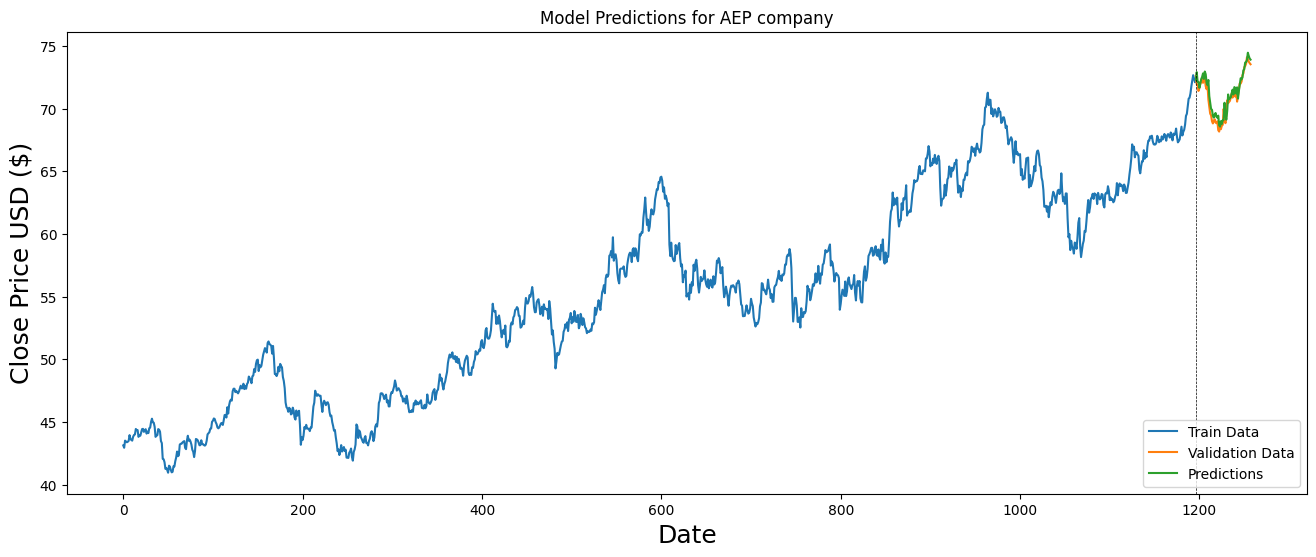

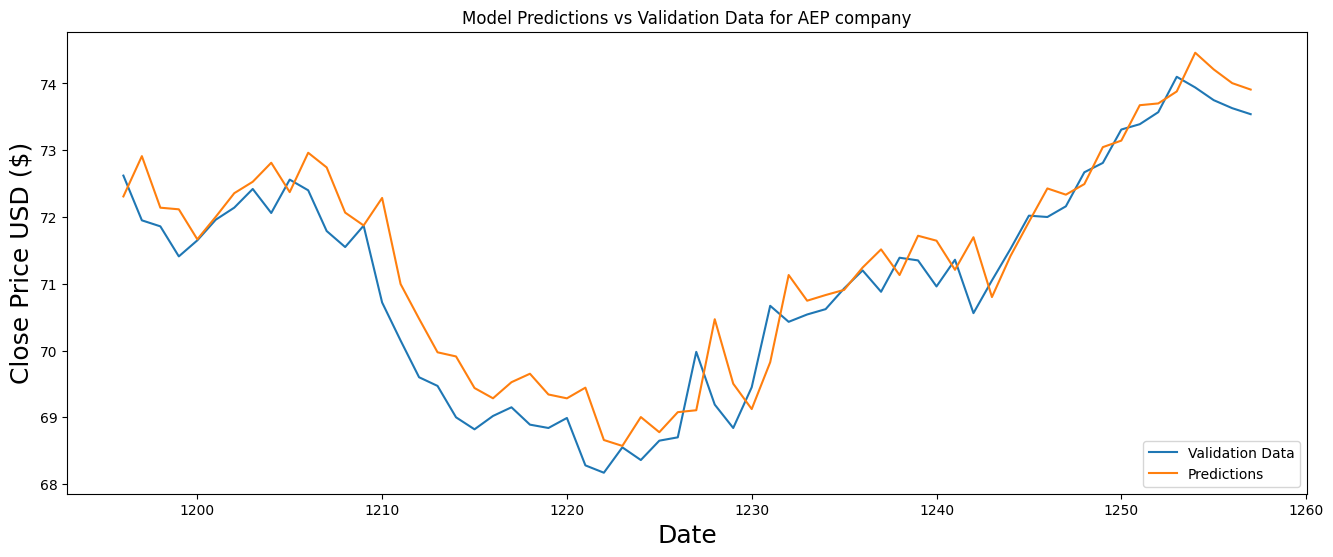

In [ ]:
plot_predictions(data_AEP, training_data_len_AEP, predictions_AEP, "AEP company")

In [ ]:
print(f"RMSE for AAPL: {rmse_AAPL}")
print(f"RMSE for ABB: {rmse_ABB}")
print(f"RMSE for ABBV: {rmse_ABBV}")
print(f"RMSE for AMGN: {rmse_AMGN}")
print(f"RMSE for AEP: {rmse_AEP}")

RMSE for AAPL: 2.0867554610851946
RMSE for ABB: 0.23614176919179572
RMSE for ABBV: 0.890098521906519
RMSE for AMGN: 7.681006555594205
RMSE for AEP: 0.5736313075147702
